In [26]:
library(tidyverse)
library(umap)

# README
### Description
Here microbiome data used in FemAI can be found as well as some small 
processing tools.

### Raw Data
The data is publically available, all RAW data can be found [here](https://entrepot.recherche.data.gouv.fr/dataset.xhtml?persistentId=doi:10.57745/7IVO3E)

1. `metadata_2250_CRC_cohort_20231114.tsv`
   This file contains all metadata, the sample columns values are the column
   names used in `species_signal_2250_CRC_cohort_20231115.tsv`
2. `species_signal_2250_CRC_cohort_20231115.tsv` contains the samples as columns
   and the MSPs (taxa information) as rows

### Scripts for extraction
1. The script `generateMSPcsv.py` is available and can be extended, it merges 
   the MSP info and the columns `study_accession` and `country` into a 
   `mergedMSP.tsv` file. It can easily be modified to include other columns in
   the merge

### Extracted data
1. `mergedMSP.tsv` contains
   - All MSP expression data
   - country
   - study accession (batch)

## Best studies:
- PRJEB27928 (GERMANY)
- PRJEB6070  (FRANCE)
- PRJNA429097 (CHINA)
- PRJEB10878 (CHINA)

# plots

In [27]:
pca_plot <- function(df, batch_info, title, path = "", color_column = "condition", shape_column = "lab") {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample") %>% 
    left_join(batch_info,  by = "sample") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))
  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes_string(col=color_column, shape=shape_column), size=2) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot)
  }
}


In [28]:
# boxplot
boxplot_pg <- function(protein_matrix, title, path = "") {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "sample", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = sample, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 1.5, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 5)) +
    labs(title = title) 

  if (path == "") {
    return(boxplot)
  } else {
    ggsave(path, boxplot)
  }
}

In [29]:
heatmap_plot <- function(pg_matrix, batch_info, name, plot_name_prefix){
    cor_matrix <- cor(na.omit(pg_matrix), use = "pairwise.complete.obs")
    pheatmap::pheatmap(cor_matrix, 
                        annotation_col = select(batch_info, c(condition, lab)),
                        treeheight_row = 0, treeheight_col = 0, 
                        fontsize_row = 5, fontsize_col = 5,
                        width = 7, height = 7,
                        main = paste0(name, ' heatmap'),
                        filename = plot_name_prefix)
}


In [30]:
plot_three_plots <- function(pg_matrix, batch_info, plot_name_prefix, subname, number){

        batch_info <- batch_info %>%
                mutate(file = case_when(
                lab %in% c('lab_A', 'lab_E') ~ str_split(file, "_") %>% 
                map_chr(~ if (length(.x) == 4) paste(.x[1], .x[2], .x[4], sep = "_") else paste(.x[1], .x[2], sep = "_")),
                
                lab == 'lab_C' ~ str_split(file, "_") %>% 
                map_chr(~ paste(.x[5], .x[6], sep = "_")),
                
                lab == 'lab_D' ~ str_split(file, "_") %>% 
                map_chr(~ paste(.x[6], .x[8], sep = "_")),
                
                TRUE ~ file
        ))

        rownames(batch_info) <- batch_info$file
        colnames(pg_matrix) <- batch_info$file


        boxplot_pg(pg_matrix, 
                paste0(subname, ' boxplot'), 
                paste0(plot_name_prefix, "_", subname, "_", number, "_boxplot.png")
        )

        pca_plot(pg_matrix,
                batch_info, 
                paste0(subname, ' pca'), 
                paste0(plot_name_prefix, "_", subname, "_", number, "_pca.png")
        )

        heatmap_plot(pg_matrix, 
                batch_info, 
                subname, 
                paste0(plot_name_prefix, "_", subname, "_", number, "_heatmap.png")
        )

}

# Check Microbiome data

In [31]:
metadata <- read.csv('/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/metadata_2250_CRC_cohort_20231114.tsv', sep = '\t') %>%
    filter(is.na(to_exclude)) %>%
    mutate(class = as.factor(class), country = as.factor(country)) %>%
    # remove adenoma samples
    filter(class != "adenoma") %>%
    # keep only data from best studies list
    filter(study_accession %in% c("PRJEB27928", "PRJEB6070", "PRJEB10878", "PRJNA429097")) %>%
    filter(!(study_accession == "PRJEB6070" & country == "DEU"))
dim(metadata)
head(metadata)

[1] 489  34

,sample,HQ_clean_read_count,gut_mapped_read_count,gut_mapped_pc,oral_mapped_read_count,oral_mapped_pc,MGS,low_read,low_map,excluded,⋯,body_site,body_subsite,health_status,host_phenotype,host_subphenotype,gender,age,bmi,class,to_exclude
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>
1,SRS2821229,33149876,24527825,73.99070,24527825,73.99070,287,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,48,22.68,healthy,NA
2,SRS2821228,31521340,25656324,81.39351,25656324,81.39351,111,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,51,23.23,healthy,NA
3,SRS2821227,38953502,34039345,87.38456,34039345,87.38456,255,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,29,23.73,healthy,NA
4,SRS2821226,39822130,33152273,83.25088,33152273,83.25088,437,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,49,22.19,healthy,NA
5,SRS2821225,40534780,32379342,79.88039,32379342,79.88039,288,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,60,23.53,healthy,NA
6,SRS2821224,36754902,31519949,85.75713,31519949,85.75713,312,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,48,23.21,healthy,NA


In [32]:
colnames(metadata)

[1] "sample"                     "HQ_clean_read_count"       
 [3] "gut_mapped_read_count"      "gut_mapped_pc"             
 [5] "oral_mapped_read_count"     "oral_mapped_pc"            
 [7] "MGS"                        "low_read"                  
 [9] "low_map"                    "excluded"                  
[11] "excluded_comment"           "sel_Beghini_2021"          
[13] "study_accession"            "sample_accession"          
[15] "secondary_sample_accession" "instrument_platform"       
[17] "instrument_model"           "library_layout"            
[19] "sample_alias"               "mgp_sample_alias"          
[21] "westernised"                "country"                   
[23] "individual_id"              "timepoint"                 
[25] "body_site"                  "body_subsite"              
[27] "health_status"              "host_phenotype"            
[29] "host_subphenotype"          "gender"                    
[31] "age"                        "bmi"                       
[33] "class"                      "to_exclude"

In [33]:
metadata %>% group_by(class) %>% summarise(n = n()) %>% arrange(desc(n)) 

class,n
<fct>,<int>
healthy,261
CRC,228


In [34]:
merged_msp <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/mergedMSP.tsv", sep = "\t") %>%
    filter(sample %in% metadata$sample) %>%
    select(-c(msp_id)) %>% #study_accession, country, 
    column_to_rownames("sample") #%>%
    # t() %>% as.data.frame() 
dim(merged_msp)
head(merged_msp)

[1]  489 2539

,study_accession,country,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,⋯,msp_2943,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SRS2821229,PRJNA429097,CHN,0,0,0.000000e+00,0.000000e+00,1.456783e-06,0,6.344335e-09,0.000000e+00,⋯,0.000000e+00,4.172572e-08,0,0,0,0,0,0,0,0
SRS2821228,PRJNA429097,CHN,0,0,4.165923e-07,0.000000e+00,3.250552e-05,0,4.085093e-07,0.000000e+00,⋯,0.000000e+00,1.498208e-08,0,0,0,0,0,0,0,0
SRS2821227,PRJNA429097,CHN,0,0,7.311750e-08,0.000000e+00,6.101269e-07,0,1.851300e-06,8.509927e-07,⋯,1.392061e-08,0.000000e+00,0,0,0,0,0,0,0,0
SRS2821226,PRJNA429097,CHN,0,0,6.074974e-07,1.045097e-06,1.255605e-07,0,2.882697e-08,9.894180e-08,⋯,0.000000e+00,8.757560e-09,0,0,0,0,0,0,0,0
SRS2821225,PRJNA429097,CHN,0,0,0.000000e+00,0.000000e+00,2.382466e-07,0,5.413065e-07,8.359072e-06,⋯,1.881317e-08,1.264270e-08,0,0,0,0,0,0,0,0
SRS2821224,PRJNA429097,CHN,0,0,1.400475e-07,0.000000e+00,6.468168e-07,0,2.704382e-07,1.906478e-07,⋯,3.247878e-08,1.330258e-08,0,0,0,0,0,0,0,0


In [35]:
merged_msp %>%
  group_by(study_accession, country) %>%
  summarise(n = n())

ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `instrument_platform` is not found.


In [37]:
metadata %>%
  group_by(study_accession, country, instrument_model) %>%
  summarise(n = n())

`summarise()` has grouped output by 'study_accession', 'country'. You can
override using the `.groups` argument.


study_accession,country,instrument_model,n
<chr>,<fct>,<chr>,<int>
PRJEB10878,CHN,Illumina HiSeq 2000,111
PRJEB27928,DEU,Illumina HiSeq 2000,15
PRJEB27928,DEU,Illumina HiSeq 4000,60
PRJEB6070,FRA,Illumina HiSeq 2000,110
PRJNA429097,CHN,HiSeq X Ten,193


In [38]:
metadata$Study_Equip <- paste(metadata$study_accession, metadata$instrument_model, sep = "_")

In [459]:
# dim(merged_msp)

# merged_msp <- merged_msp %>%
#   select(-c(study_accession, country)) %>%
#   filter(rowSums(.) != 0) %>%
#   t() %>% as.data.frame() %>%
#   filter(rowSums(.) != 0) 

# dim(merged_msp)




In [15]:
more_then_n <- 20

msp_to_keep <- merged_msp %>%
    select(-country) %>%
    group_by(study_accession) %>%
    summarise(across(everything(), ~sum(.x != 0))) %>%
    # transpose and convert to data frame 
    t() %>% as.data.frame() %>%
    #use study_accession row as colnames
    setNames(., .[1, ]) %>%  slice(-1) %>%
    # transform all columns to numeric
    mutate_all(as.numeric) %>%
    mutate(keep = ifelse(PRJEB27928 > more_then_n & PRJEB6070 > more_then_n & PRJEB10878 > more_then_n & PRJNA429097 > more_then_n, 1, 0)) %>%
    filter(keep == 1) %>%
    rownames_to_column("msp") %>%
    .[,'msp']

length(msp_to_keep)


[1] 275

In [16]:
dim(merged_msp)
merged_msp <- merged_msp[, c('study_accession',msp_to_keep)]
dim(merged_msp)

[1]  489 2539

[1] 489 276

In [17]:
merged_msp %>%
  group_by(study_accession) %>%
  summarise(n = n())

study_accession,n
<chr>,<int>
PRJEB10878,111
PRJEB27928,75
PRJEB6070,110
PRJNA429097,193


In [18]:
merged_msp <- merged_msp %>%
    select(-study_accession) %>%
    t() %>% as.data.frame() 

merged_msp <- merged_msp[, metadata$sample]

In [19]:
sum(merged_msp == 0)
sum(merged_msp == 0) / (nrow(merged_msp) * ncol(merged_msp))

[1] 54150

[1] 0.4026771

## PCA plots

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


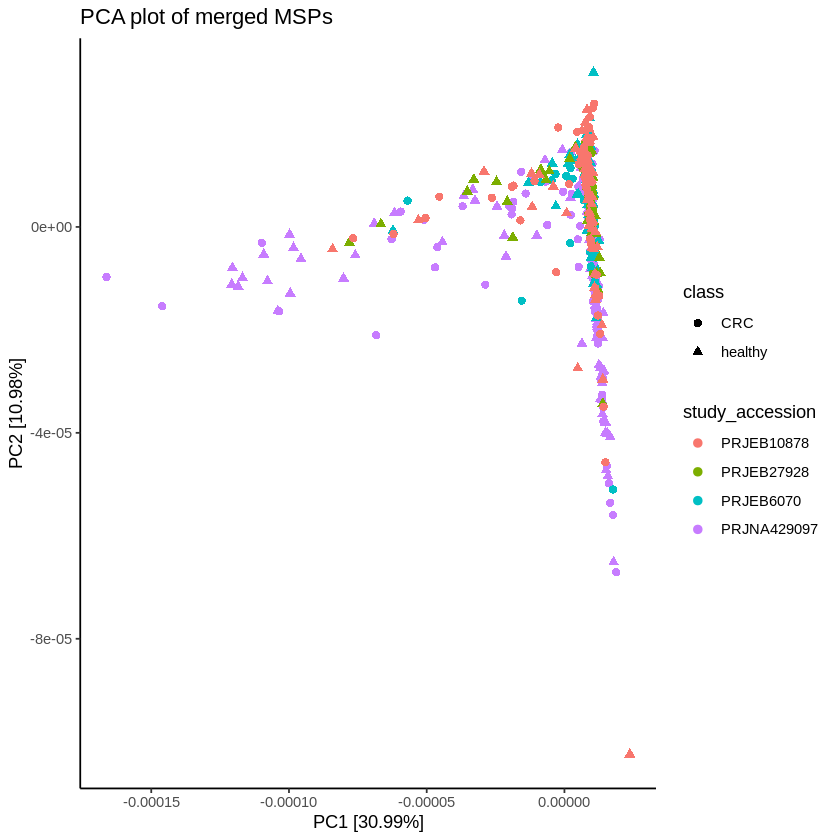

In [20]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp, metadata, 
        title = "PCA plot of merged MSPs", 
        color_column = "study_accession", shape_column = "class")

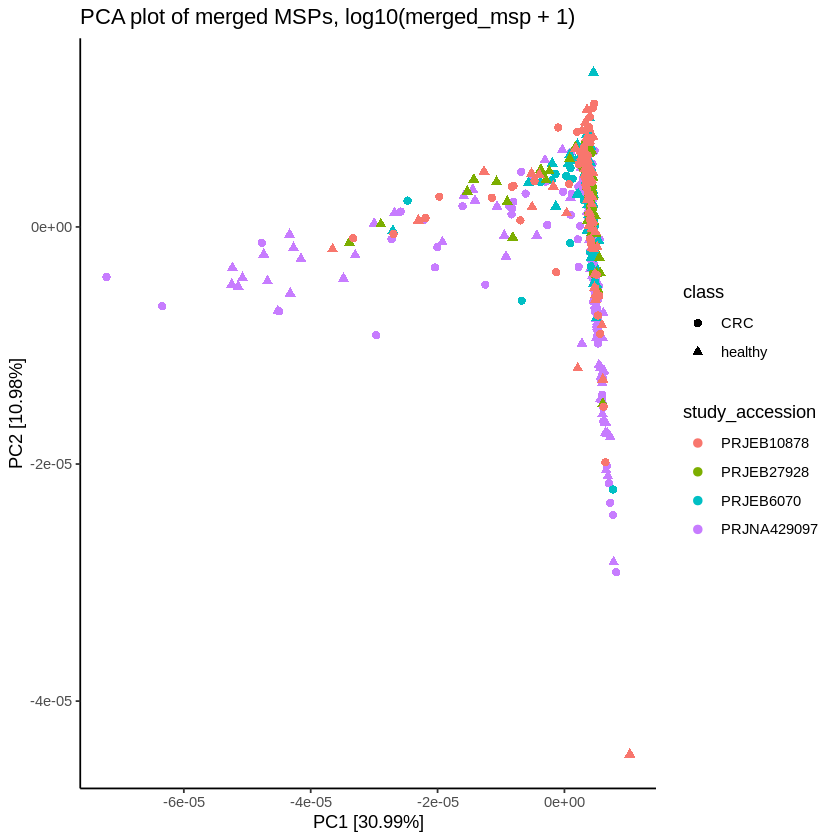

In [21]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(log10(merged_msp+1), metadata, 
        title = "PCA plot of merged MSPs, log10(merged_msp + 1)", 
        color_column = "study_accession", shape_column = "class")

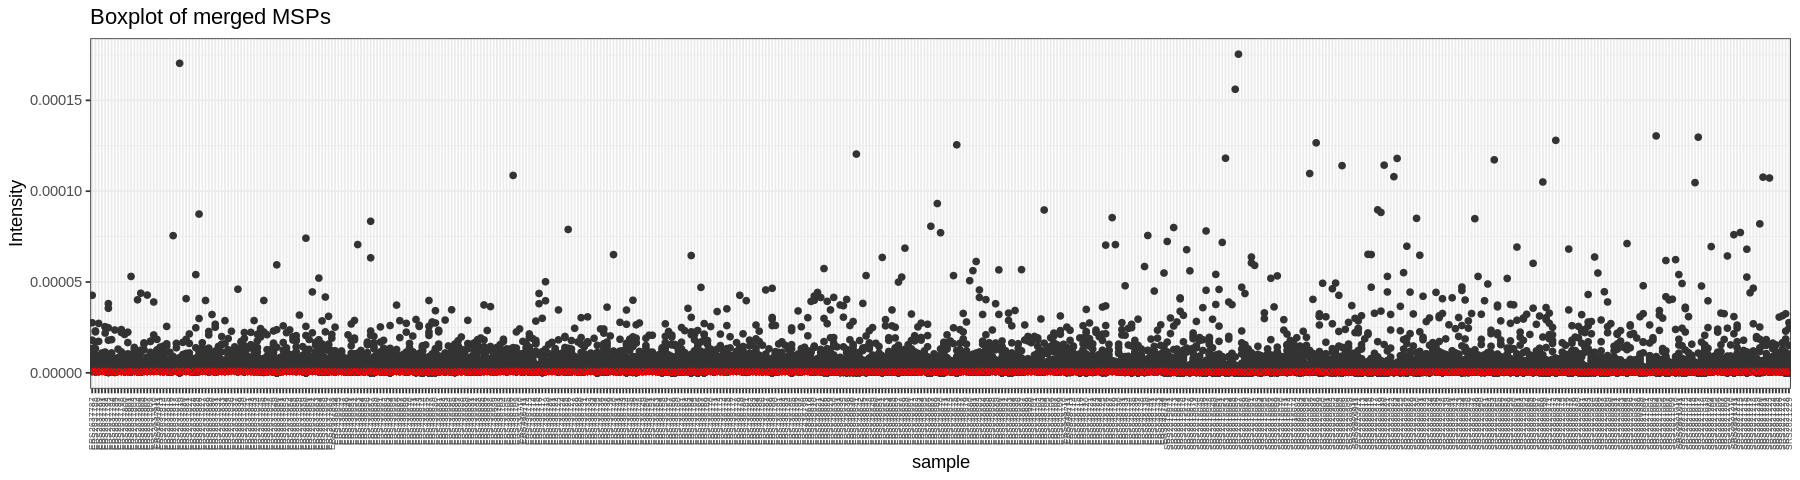

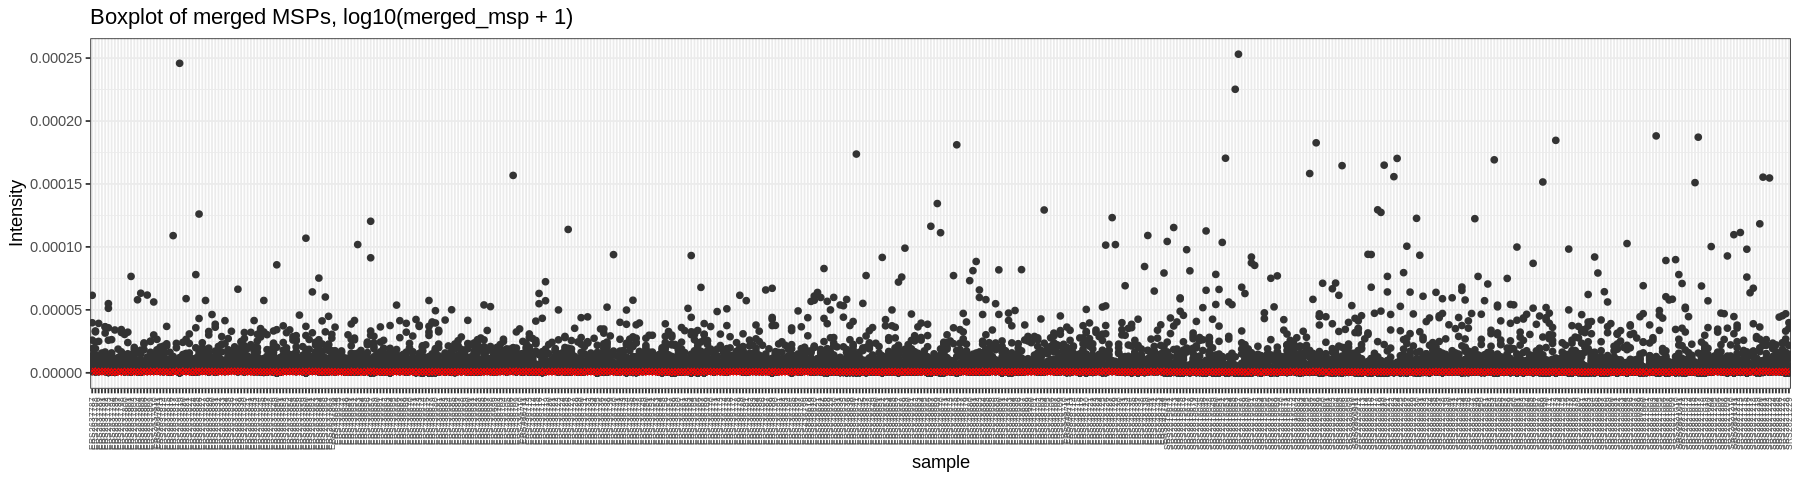

In [467]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_pg(merged_msp, title = "Boxplot of merged MSPs")
boxplot_pg(log2(merged_msp+1), title = "Boxplot of merged MSPs, log10(merged_msp + 1)")

In [432]:
library(ggsci)

In [468]:
umap_result = umap(t(log2(merged_msp + 1)))

umap_plot = data.frame(umap_result$layout)
umap_plot <- umap_plot %>% 
    rownames_to_column() %>%
    rename(sample = rowname) %>%
    left_join(metadata[,c('sample', 'country', 'class', 'study_accession', 'instrument_model')] ,  by = "sample") %>%
    column_to_rownames("sample")


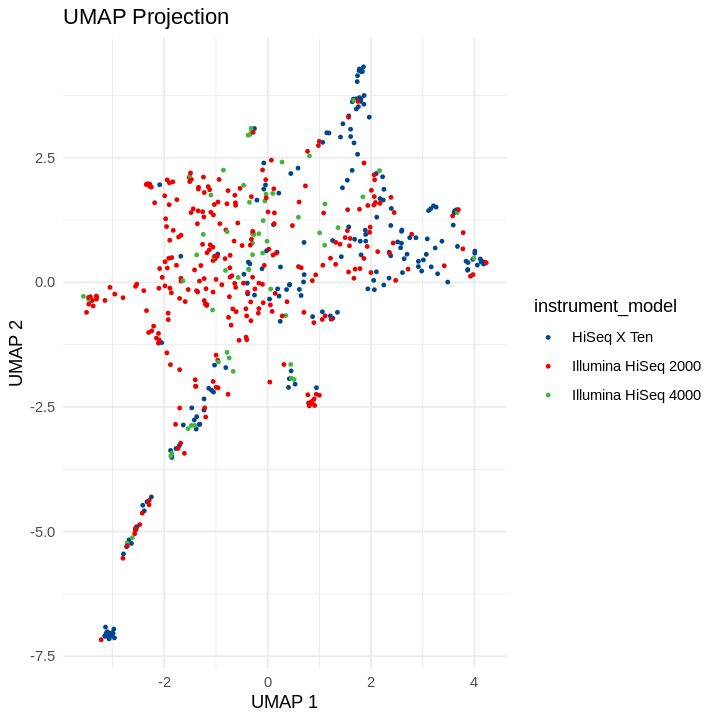

In [469]:

options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=instrument_model), size = 0.7) +
    scale_color_lancet() + 
    theme_minimal() +
    labs(title = "UMAP Projection", x = "UMAP 1", y = "UMAP 2")


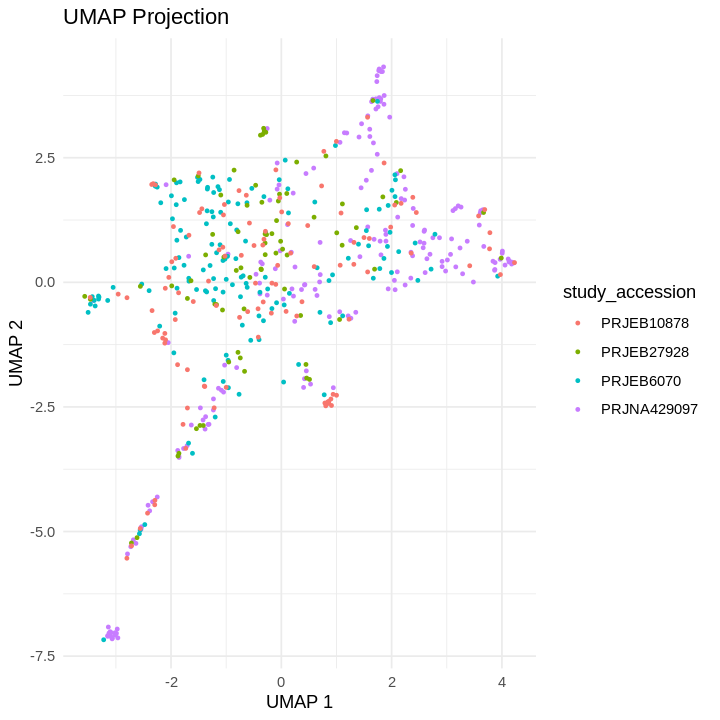

In [470]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=study_accession), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection", x = "UMAP 1", y = "UMAP 2")

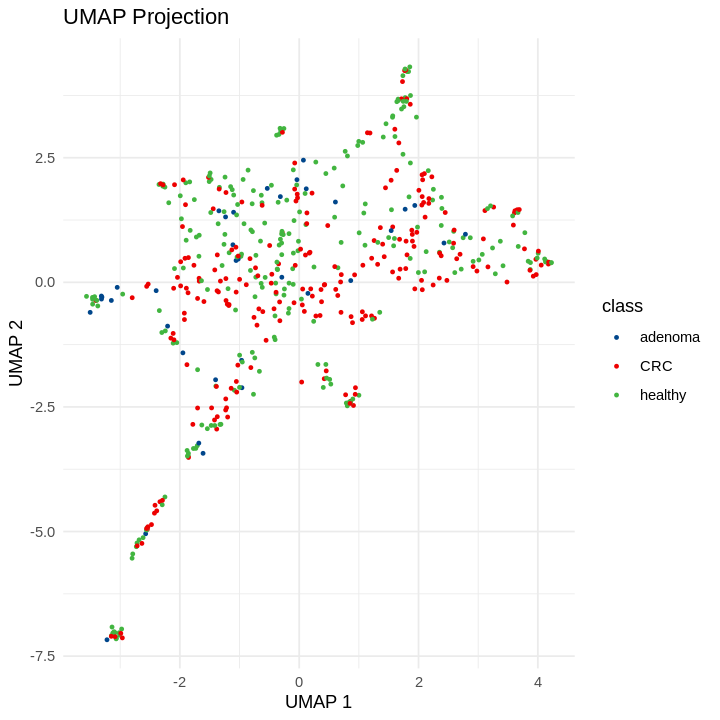

In [471]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=class), size = 0.7) +
    scale_color_lancet() + 
    theme_minimal() +
    labs(title = "UMAP Projection", x = "UMAP 1", y = "UMAP 2")

# Correction?

In [22]:
library(limma)

In [23]:
metadata <- metadata %>%
    mutate(study_accession = as.factor(study_accession),
           class = as.factor(class))

## only batch

In [24]:
# get minimal value from merged_msp excluding NA and 0
min_value <- min(merged_msp[merged_msp != 0 & !is.na(merged_msp)], na.rm = TRUE)

merged_msp_corrected <- removeBatchEffect(log2(merged_msp + 0.5*min_value), metadata[['study_accession']]) %>% as.data.frame()

In [475]:
umap_result = umap(t(merged_msp_corrected))

umap_plot = data.frame(umap_result$layout)
umap_plot <- umap_plot %>% 
    rownames_to_column() %>%
    rename(sample = rowname) %>%
    left_join(metadata[,c('sample', 'country', 'class', 'study_accession', 'instrument_model')] ,  by = "sample") %>%
    column_to_rownames("sample")


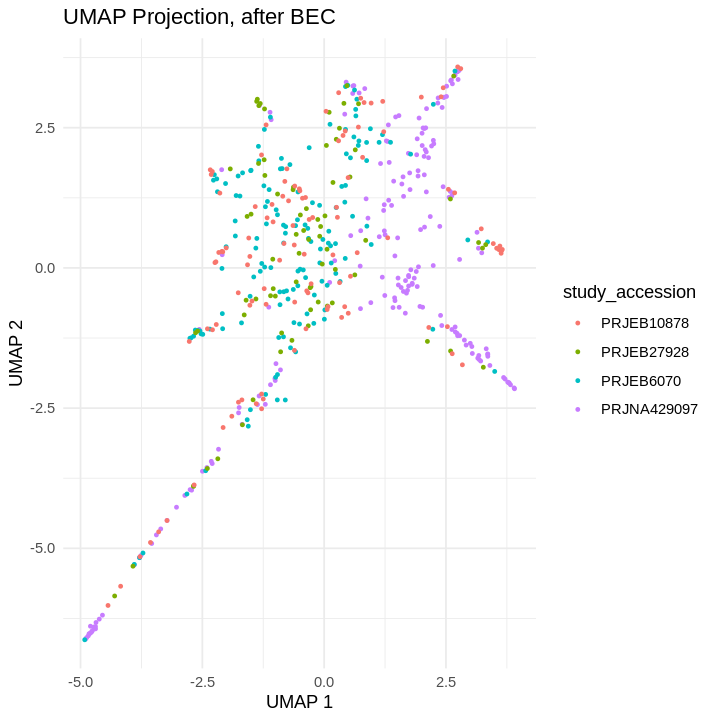

In [476]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=study_accession), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

## batch + class

In [42]:

design=model.matrix(~class, data = metadata)

# get minimal value from merged_msp excluding NA and 0
min_value <- min(merged_msp[merged_msp != 0 & !is.na(merged_msp)], na.rm = TRUE)

merged_msp_corrected <- removeBatchEffect(log2(merged_msp + 0.5*min_value), metadata$Study_Equip, design = design) %>% as.data.frame()


ERROR: Error in parse(text = x, srcfile = src): <text>:5:81: unexpected symbol
4: # get minimal value from merged_msp excluding NA and 0
5: min_value <- min(merged_msp[merged_msp != 0 & !is.na(merged_msp)], na.rm = TRUE).astype
                                                                                   ^


In [43]:
merged_msp

,study_accession,country,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,⋯,msp_2943,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SRS2821229,PRJNA429097,CHN,0.000000e+00,0,0.000000e+00,0.000000e+00,1.456783e-06,0,6.344335e-09,0.000000e+00,⋯,0.000000e+00,4.172572e-08,0,0,0,0,0,0,0,0
SRS2821228,PRJNA429097,CHN,0.000000e+00,0,4.165923e-07,0.000000e+00,3.250552e-05,0,4.085093e-07,0.000000e+00,⋯,0.000000e+00,1.498208e-08,0,0,0,0,0,0,0,0
SRS2821227,PRJNA429097,CHN,0.000000e+00,0,7.311750e-08,0.000000e+00,6.101269e-07,0,1.851300e-06,8.509927e-07,⋯,1.392061e-08,0.000000e+00,0,0,0,0,0,0,0,0
SRS2821226,PRJNA429097,CHN,0.000000e+00,0,6.074974e-07,1.045097e-06,1.255605e-07,0,2.882697e-08,9.894180e-08,⋯,0.000000e+00,8.757560e-09,0,0,0,0,0,0,0,0
SRS2821225,PRJNA429097,CHN,0.000000e+00,0,0.000000e+00,0.000000e+00,2.382466e-07,0,5.413065e-07,8.359072e-06,⋯,1.881317e-08,1.264270e-08,0,0,0,0,0,0,0,0
SRS2821224,PRJNA429097,CHN,0.000000e+00,0,1.400475e-07,0.000000e+00,6.468168e-07,0,2.704382e-07,1.906478e-07,⋯,3.247878e-08,1.330258e-08,0,0,0,0,0,0,0,0
SRS2821223,PRJNA429097,CHN,0.000000e+00,0,1.688635e-07,0.000000e+00,5.132948e-07,0,9.943392e-07,3.202553e-07,⋯,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0
SRS2821222,PRJNA429097,CHN,0.000000e+00,0,1.686861e-07,0.000000e+00,5.879323e-07,0,3.345726e-07,9.863992e-07,⋯,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0
SRS2821221,PRJNA429097,CHN,0.000000e+00,0,1.688915e-08,0.000000e+00,1.262349e-06,0,3.269329e-08,1.753220e-07,⋯,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0


In [478]:
umap_result = umap(t(merged_msp_corrected))

umap_plot = data.frame(umap_result$layout)
umap_plot <- umap_plot %>% 
    rownames_to_column() %>%
    rename(sample = rowname) %>%
    left_join(metadata[,c('sample', 'country', 'class', 'study_accession', 'instrument_model')] ,  by = "sample") %>%
    column_to_rownames("sample")


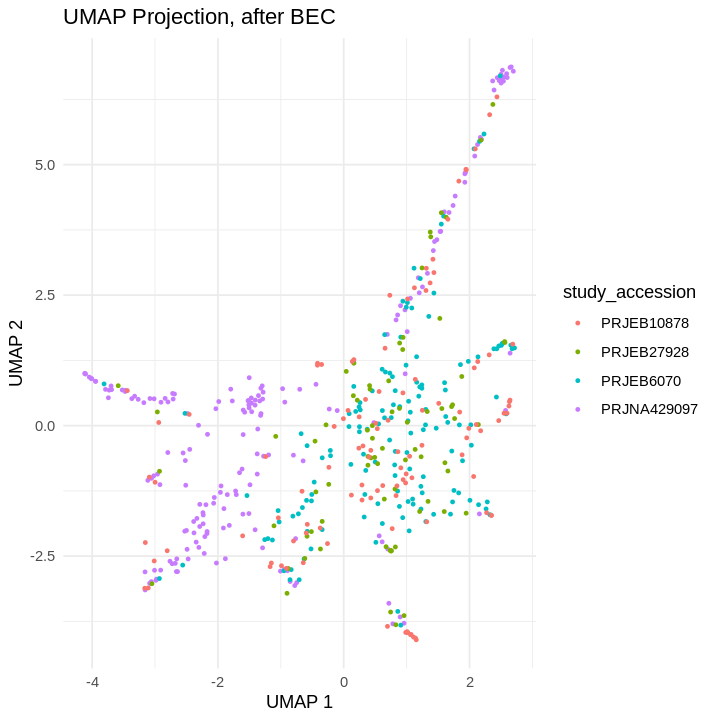

In [479]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=study_accession), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

## replace 0 with NA

In [480]:
# replace 0 with NA
merged_msp_NA <- merged_msp
merged_msp_NA[merged_msp_NA == 0] <- NA
merged_msp_NA <- log2(merged_msp_NA + 1)

In [483]:

design=model.matrix(~class, data = metadata)
merged_msp_NA_corrected <- removeBatchEffect(merged_msp_NA, metadata$study_accession, design = design) %>% as.data.frame()

merged_msp_NA_corrected[is.na(merged_msp_NA)] <- 0

In [484]:
umap_result = umap(t(merged_msp_NA_corrected))

umap_plot = data.frame(umap_result$layout)
umap_plot <- umap_plot %>% 
    rownames_to_column() %>%
    rename(sample = rowname) %>%
    left_join(metadata[,c('sample', 'country', 'class', 'study_accession', 'instrument_model')] ,  by = "sample") %>%
    column_to_rownames("sample")


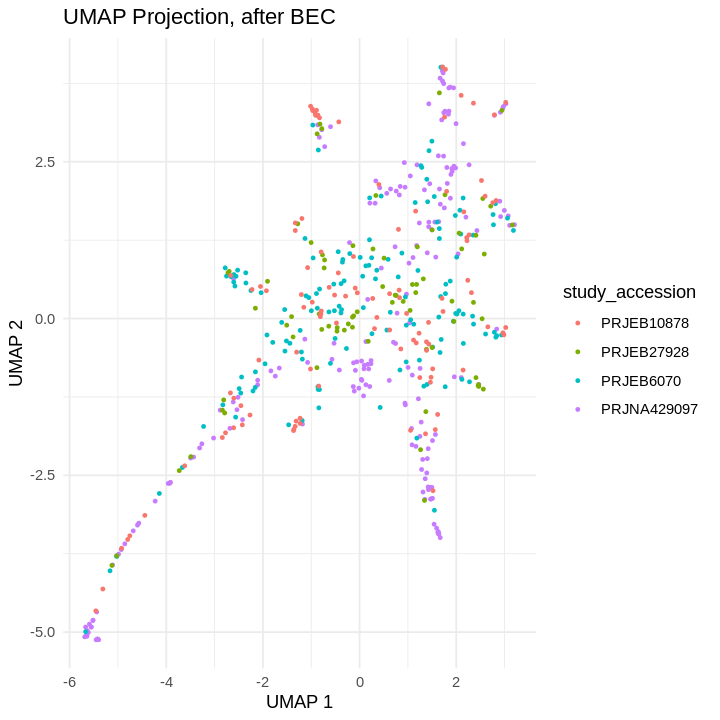

In [487]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=study_accession), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

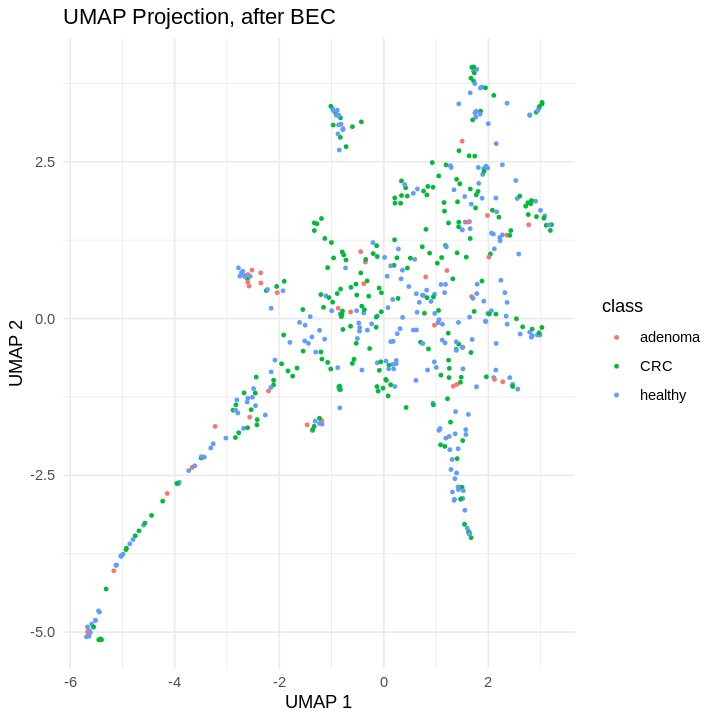

In [486]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=class), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")